In [58]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [59]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [60]:
df = pd.read_csv(csv_path)

In [61]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)', "VPmax (mbar)","VPact (mbar)","sh (g/kg)","H2OC (mmol/mol)", "rh (%)"]

In [62]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3),VPmax (mbar),VPact (mbar),sh (g/kg),H2OC (mmol/mol),rh (%)
Date Time,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75,3.33,3.11,1.94,3.12,93.3
01.01.2009 00:20:00,996.57,-8.41,1309.80,3.23,3.02,1.89,3.03,93.4
01.01.2009 00:30:00,996.53,-8.51,1310.24,3.21,3.01,1.88,3.02,93.9
01.01.2009 00:40:00,996.51,-8.31,1309.19,3.26,3.07,1.92,3.08,94.2
01.01.2009 00:50:00,996.51,-8.27,1309.00,3.27,3.08,1.92,3.09,94.1


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

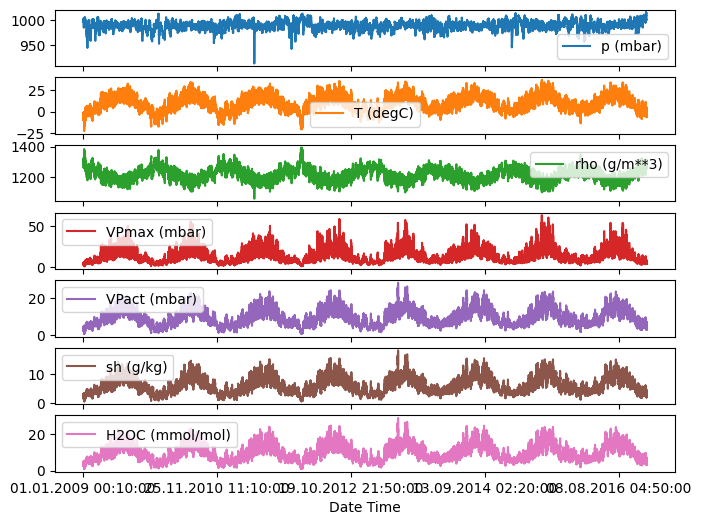

In [10]:
features.plot(subplots=True)

In [63]:
TRAIN_SPLIT = 300000

In [64]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [65]:
dataset = (dataset-data_mean)/data_std

In [66]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [67]:
past_history = 720
# future_target = 72 #12 hrs, observation every 10 minutes
# 6, 8, 12, 24 hrs -> 36, 48, 72, 144
targets = [36, 48, 72, 144]
STEP = 6
future_target = 48

In [ ]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                TRAIN_SPLIT, past_history,
                                                future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                            TRAIN_SPLIT, None, past_history,
                                            future_target, STEP)
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

EPOCHS = 20
EVALUATION_INTERVAL = 200
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

hrs = future_target/6
path_name = "my_saved_lstm_temp" + str(hrs) + "hrsjena.keras"
multi_step_model.save(path_name)



In [18]:
def create_time_steps(length):
  return list(range(-length, 0))

In [19]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

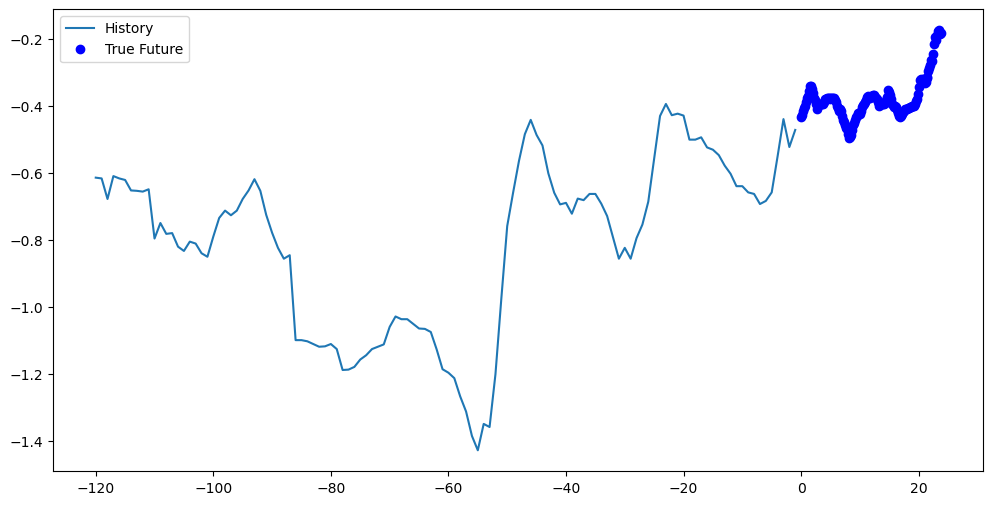

In [20]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [22]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


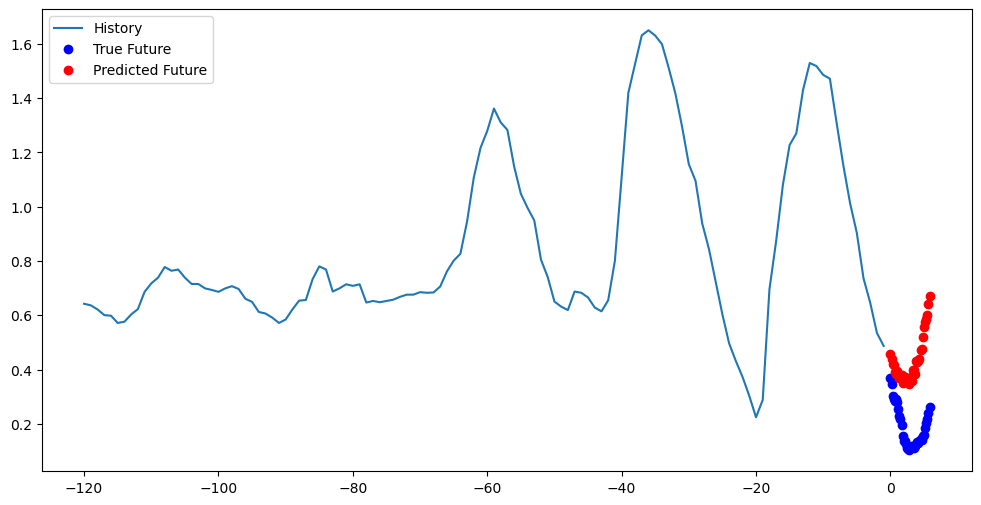

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


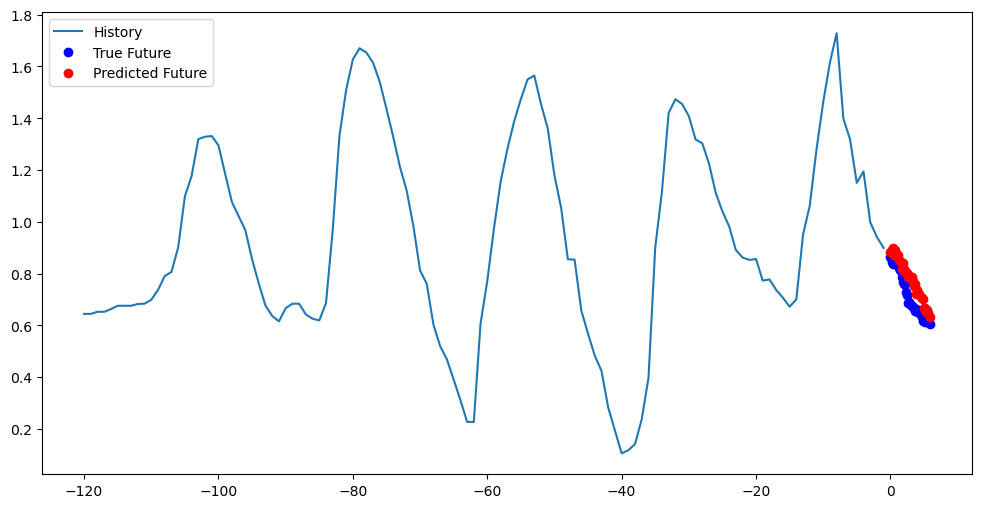

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


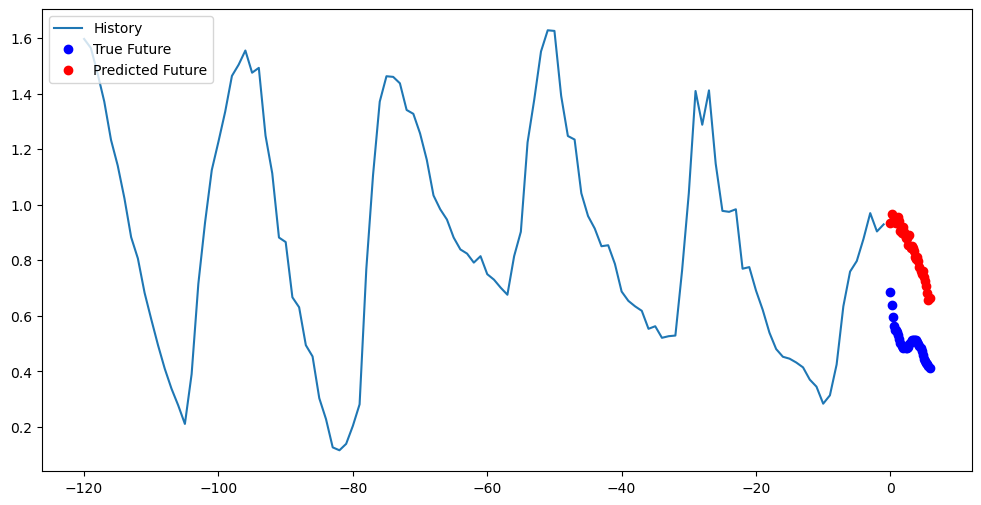

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


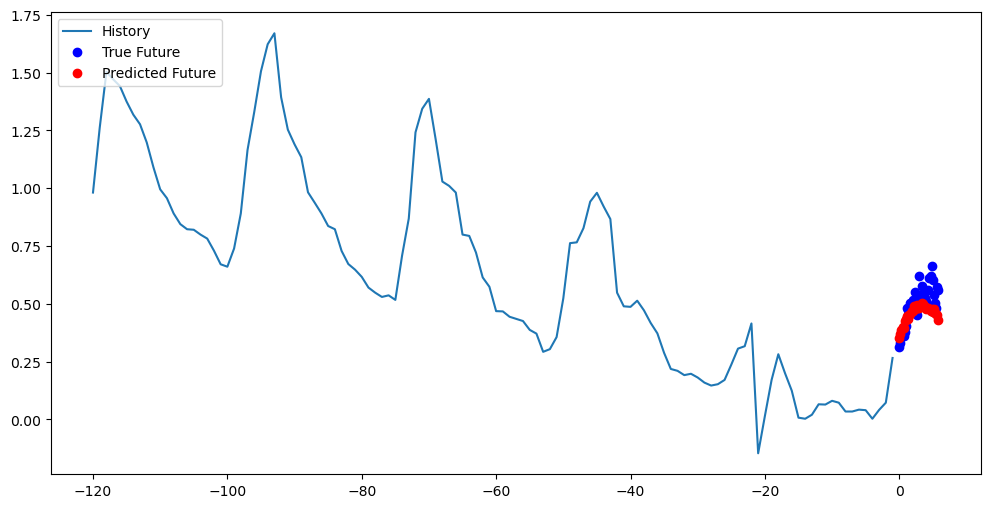

In [56]:
for x, y in val_data_multi.take(3):

  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])